<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# based on https://gemini.google.com/app/d0884ebba6891069
# original version in tf:  https://spaces.ac.cn/archives/4439

# created by https://gemini.google.com/app/d0884ebba6891069
# practice: https://colab.research.google.com/drive/1p2z2fqHCSlAmPiq8In4Ls2FZYsq77gQh#scrollTo=Aomv8xSV-aoO

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad as torch_grad
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os

# Create output directory for generated images
os.makedirs('out_pytorch', exist_ok=True)

## 1. Hyperparameters
# =============================================
batch_size = 100
width, height = 28, 28
mnist_dim = width * height  # 784
random_dim = 10             # Size of the latent z vector
n_iterations = 20000        # Total training iterations (reduced for a reasonable demo time)
n_critic = 5                # Number of discriminator updates per generator update
lambda_gp = 10              # Gradient penalty coefficient
lr = 1e-4
beta1 = 0.5
beta2 = 0.999               # Default beta2 for Adam

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


## 2. Data Loading
# =============================================
transform = transforms.Compose([
    transforms.ToTensor(), # Scales images to [0.0, 1.0]
    # No normalization to [-1, 1] since the original generator uses sigmoid
])

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True # Ensure constant batch size
)


## 3. Model Architecture
# =============================================
# Custom weight initialization from the original script
def my_init(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, -0.05, 0.05)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(random_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, mnist_dim),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def forward(self, input):
        return self.main(input)

# Discriminator (Critic) Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(mnist_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32),
            nn.ReLU(True),
            nn.Linear(32, 1)  # No final activation for the WGAN critic
        )

    def forward(self, input):
        return self.main(input)


## 4. Initialization
# =============================================
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Apply custom weight initialization
generator.apply(my_init)
discriminator.apply(my_init)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))


## 5. Gradient Penalty Function
# =============================================
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(batch_size, 1, device=device)

    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)

    # Use a dummy tensor of ones for gradient calculation
    fake = torch.ones(batch_size, 1, device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch_grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)

    # This calculation is based on the original TF script's one-sided penalty
    # tf.reduce_mean(tf.nn.relu(grad_norm - 1.))
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = torch.mean(torch.nn.functional.relu(gradient_norm - 1.0))

    return lambda_gp * gradient_penalty

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


In [3]:
## 6. Training Loop
# =============================================
print("Starting Training...")
data_iter = iter(dataloader)

for iteration in range(1, n_iterations + 1):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    for critic_step in range(n_critic):
        optimizer_D.zero_grad()

        # Get a batch of real images
        try:
            real_images, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            real_images, _ = next(data_iter)

        real_images = real_images.view(real_images.size(0), -1).to(device)

        # Generate a batch of fake images
        z = torch.FloatTensor(batch_size, random_dim).uniform_(-1, 1).to(device)
        fake_images = generator(z).detach()

        # Get critic scores for real and fake images
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images)

        # Compute gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_images.data, fake_images.data)

        # Adversarial loss: E[D(fake)] - E[D(real)] + Gradient Penalty
        d_loss = torch.mean(fake_output) - torch.mean(real_output) + gradient_penalty

        d_loss.backward()
        optimizer_D.step()

    # -----------------
    #  Train Generator
    # -----------------
    optimizer_G.zero_grad()

    # Generate a new batch of fake images
    z_gen = torch.FloatTensor(batch_size, random_dim).uniform_(-1, 1).to(device)
    gen_imgs = generator(z_gen)

    # Generator loss: -E[D(fake)]
    # We want the generator to produce images that the discriminator scores highly.
    # NOTE: The original TF script had an incorrect G_loss that it minimized: `tf.reduce_mean(D(random_Y))`.
    # This trains the generator to make the discriminator's output *lower*, which is the opposite of the goal.
    # The correct loss is to minimize -D(G(z)).
    g_loss = -torch.mean(discriminator(gen_imgs))

    g_loss.backward()
    optimizer_G.step()

    # -----------------
    #  Log and Save Images
    # -----------------
    if iteration % 1000 == 0:
        print(f"[Iteration {iteration}/{n_iterations}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Save a grid of generated images
        with torch.no_grad():
            n_rows = 6
            z_sample = torch.FloatTensor(n_rows**2, random_dim).uniform_(-1, 1).to(device)
            generated_samples = generator(z_sample).view(-1, 1, width, height)
            save_image(generated_samples, f"out_pytorch/{iteration}.png", nrow=n_rows, normalize=True)

Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Iteration 1000/20000] [D loss: -4.2484] [G loss: -0.0562]
[Iteration 2000/20000] [D loss: -4.4698] [G loss: -0.1442]
[Iteration 3000/20000] [D loss: -4.3712] [G loss: -0.0519]
[Iteration 4000/20000] [D loss: -3.9323] [G loss: -0.0330]
[Iteration 5000/20000] [D loss: -3.7032] [G loss: 0.4836]
[Iteration 6000/20000] [D loss: -3.3828] [G loss: 0.3511]
[Iteration 7000/20000] [D loss: -4.0226] [G loss: 0.8827]
[Iteration 8000/20000] [D loss: -4.1091] [G loss: 0.9281]
[Iteration 9000/20000] [D loss: -4.2270] [G loss: -0.1347]
[Iteration 10000/20000] [D loss: -3.6579] [G loss: -0.5996]
[Iteration 11000/20000] [D loss: -3.8351] [G loss: -1.1984]
[Iteration 12000/20000] [D loss: -3.3819] [G loss: -1.3166]
[Iteration 13000/20000] [D loss: -3.3407] [G loss: -1.5581]
[Iteration 14000/20000] [D loss: -3.0997] [G loss: -1.5262]
[Iteration 15000/20000] [D loss: -3.1597] [G loss: -1.7329]
[Iteration 16000/20000] [D loss: -2.9322] [G loss: -1.8079]
[Iteration 17000/20000] [D loss: -2.7382] [G loss: -1

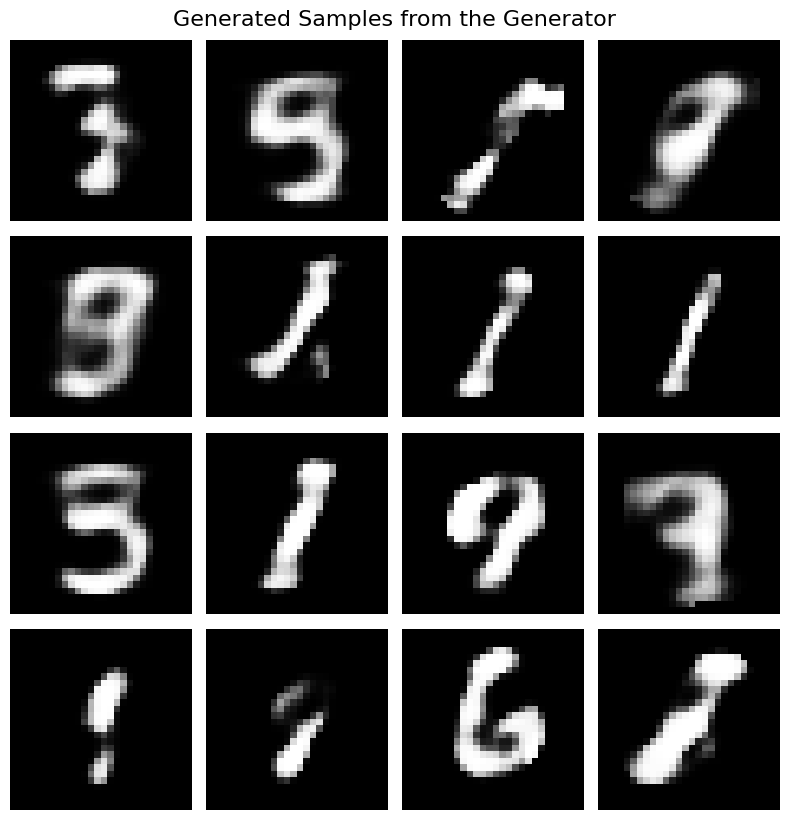

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure the generator is in evaluation mode
generator.eval()

# --- Configuration ---
num_images_to_generate = 16
n_rows = 4

# Generate images
with torch.no_grad():
    # Create a batch of latent vectors (random noise)
    z_sample = torch.FloatTensor(num_images_to_generate, random_dim).uniform_(-1, 1).to(device)

    # Generate fake images
    generated_images = generator(z_sample).cpu() # Move to CPU for plotting

    # Reshape the images to 28x28
    generated_images = generated_images.view(num_images_to_generate, 28, 28)

# --- Plotting the images ---
fig, axes = plt.subplots(n_rows, n_rows, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Generated Samples from the Generator", y=1.02, fontsize=16)
plt.show()

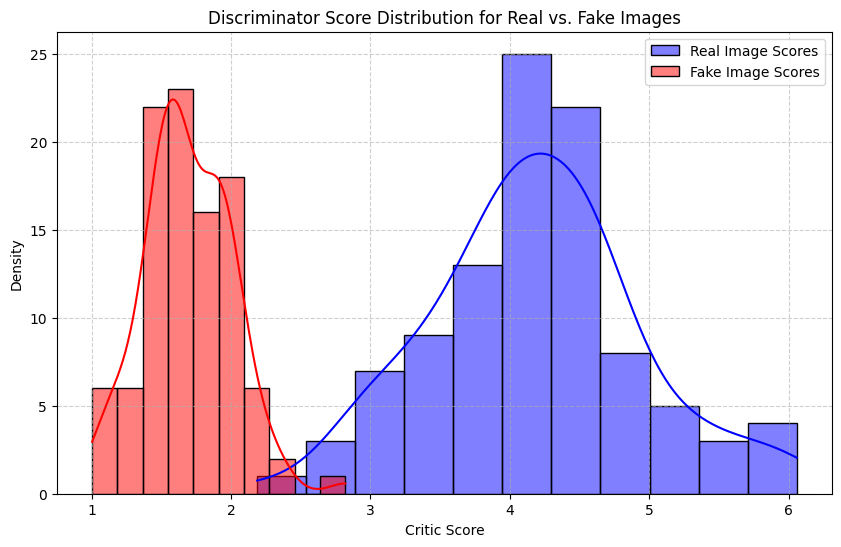

Average score for REAL images: 4.1782
Average score for FAKE images: 1.6933


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set models to evaluation mode
generator.eval()
discriminator.eval()

# Get a batch of real images
real_images_batch, _ = next(iter(dataloader))
real_images_batch = real_images_batch.view(real_images_batch.size(0), -1).to(device)

# Generate a batch of fake images
with torch.no_grad():
    z = torch.FloatTensor(batch_size, random_dim).uniform_(-1, 1).to(device)
    fake_images_batch = generator(z)

    # Get discriminator scores
    real_scores = discriminator(real_images_batch).cpu().numpy()
    fake_scores = discriminator(fake_images_batch).cpu().numpy()

# --- Plotting the score distributions ---
plt.figure(figsize=(10, 6))
sns.histplot(real_scores.flatten(), color="blue", label="Real Image Scores", kde=True)
sns.histplot(fake_scores.flatten(), color="red", label="Fake Image Scores", kde=True)
plt.title("Discriminator Score Distribution for Real vs. Fake Images")
plt.xlabel("Critic Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Average score for REAL images: {np.mean(real_scores):.4f}")
print(f"Average score for FAKE images: {np.mean(fake_scores):.4f}")